In [1]:
import pandas as pd
import numpy as np
import cv2
import glob

<h4> HAM10000 </h4>

In [2]:
# Get every HAM10000 image path
first_path_ham = "raw-dataset/HAM10000/HAM10000_images_part_1"
second_path_ham = "raw-dataset/HAM10000/HAM10000_images_part_2"

list_first_path = glob.glob(first_path_ham + "/*")
list_second_path = glob.glob(second_path_ham + "/*")
images_path = list_first_path + list_second_path

print("Total of the images : {}".format(len(images_path)))

Total of the images : 0


In [3]:
# Load the metadata csv files
csv_path = "raw-dataset/HAM10000/HAM10000_metadata.csv"

df = pd.read_csv(csv_path)
df_ = df[['image_id', 'dx']]
df_

,image_id,dx
0,ISIC_0027419,bkl
1,ISIC_0025030,bkl
2,ISIC_0026769,bkl
3,ISIC_0025661,bkl
4,ISIC_0031633,bkl
...,...,...
10010,ISIC_0033084,akiec
10011,ISIC_0033550,akiec
10012,ISIC_0033536,akiec
10013,ISIC_0032854,akiec


In [4]:
import json

# Load JSON for label mapping
f = open("utils/label_encode.json")

labels_map = json.load(f)
print(labels_map)

f.close()

{'actinic keratosis': {'label': 0, 'abbreviation': 'akiec'}, 'basal cell carcinoma': {'label': 1, 'abbreviation': 'bcc'}, 'pigmented benign keratosis': {'label': 2, 'abbreviation': 'bkl'}, 'dermatofibroma': {'label': 3, 'abbreviation': 'df'}, 'melanoma': {'label': 4, 'abbreviation': 'mel'}, 'melanocytic nevus': {'label': 5, 'abbreviation': 'nv'}, 'vascular lesions': {'label': 6, 'abbreviation': 'vasc'}}


In [5]:
'''Matching file through var images_path, parameter of matching using filename via path and image_id on var df_'''
ham_dataset_label = []

# Looping through path and file matching with image id
for idx, path in enumerate(images_path):
    # Replace slash inconsistencies on WINDOWS
    path = path.replace("//", "/").replace("\\", "/")
    # Split and get the filename
    fname = path.split("/")[3].split(".")[0]
    # Get item index by matching image_id and filename
    # Unpack Tuple and Numpy
    index = np.where(df_['image_id'].values == fname)[0][0]
    # Get label from given index on var df_
    label = df_.iloc[index]['dx']
    # Match with encoding mapping
    for keys, value in labels_map.items():
        if value['abbreviation'] == label:
            ham_dataset_label.append(value['label'])


Filename : raw-dataset/HAM10000/HAM10000_images_part_1\ISIC_0024538.jpg
Encoded Label :  5


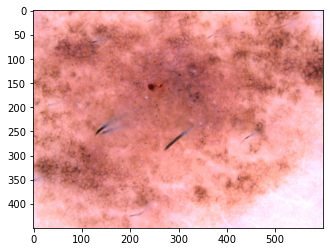

In [6]:
# Let's load the sample
import matplotlib.pyplot as plt

image = cv2.imread(images_path[232])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print("Filename : " + images_path[232])
print("Encoded Label : ", ham_dataset_label[232])
plt.imshow(image)

<h4> Load ISIC path </h4>

In [7]:
# Load folder path and eliminate any label that do not match with HAM
base_path_isic_train = "raw-dataset/ISIC/Train"
base_path_isic_test = "raw-dataset/ISIC/Test"

# Get each folder path
list_base_path_isic_train = glob.glob(base_path_isic_train + "/*")
list_base_path_isic_test = glob.glob(base_path_isic_test + "/*")


In [8]:
def extract_image_path(path):
    isic_path = []
    isic_label = []
    # Get every image path
    for idx, folder in enumerate(path):
        # Windows consistency about slash fix
        folder = folder.replace("//", "/").replace("\\", "/")
        # Get the name of label by folder name
        folder_label = folder.split("/")[3]
        # Check if label is match with HAM10000 and extract encoded label
        is_ham = False
        current_label = -1
        for key in labels_map.keys():
            if folder_label == key:
                is_ham = True
                current_label = labels_map[key]['label']
                break

        # Continue to the next label if doesn't match
        if is_ham == False:
            continue

        # Extract the path
        list_images_path = glob.glob(folder + "/*")
        for idx_sub, image_path in enumerate(list_images_path):
            isic_path.append(image_path)
            isic_label.append(current_label)

    return isic_path, isic_label

In [9]:
# Concatenate
train_isic_path, train_isic_label = extract_image_path(list_base_path_isic_train)
test_isic_path, test_isic_label = extract_image_path(list_base_path_isic_test)

all_isic_path = train_isic_path + test_isic_path
all_isic_label = train_isic_label + test_isic_label

Filename : raw-dataset/ISIC/Train/pigmented benign keratosis\ISIC_0027310.jpg
Encoded Label :  2


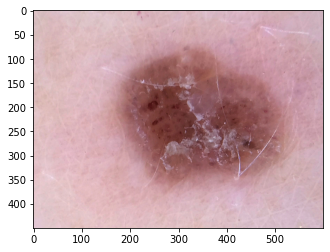

In [11]:
# Show some sample
# Let's load the sample
import matplotlib.pyplot as plt

# Change this to get result
index = 1700
image = cv2.imread(all_isic_path[index])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print("Filename : " + all_isic_path[index])
print("Encoded Label : ", all_isic_label[index])
plt.imshow(image)

In [15]:
# Merge HAM10000 and ISIC
x_path = np.array(images_path + all_isic_path)
y_path = np.array(ham_dataset_label + all_isic_label)

<h4> Early Preprocessing </h4>

In [34]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

x_path_shuffled, y_path_shuffled = shuffle(x_path, y_path, random_state=16)

In [35]:
from collections import Counter

counter = Counter(y_path_shuffled)
for k, v in counter.items():
    per= v / len(y_path) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=5, n=7078 (58.520%)
Class=4, n=1567 (12.956%)
Class=1, n=906 (7.491%)
Class=0, n=457 (3.778%)
Class=3, n=226 (1.869%)
Class=2, n=1577 (13.038%)
Class=6, n=284 (2.348%)


In [40]:
from sklearn.model_selection import StratifiedKFold as skf

skf_model = skf(n_splits=2, random_state=32, shuffle=True)
for train_idx, test_idx in skf_model.split(x_path_shuffled, y_path_shuffled):
    x_train, x_test = np.copy(x_path_shuffled[train_idx]), np.copy(x_path_shuffled[test_idx])
    y_train, y_test = np.copy(y_path_shuffled[train_idx]), np.copy(y_path_shuffled[test_idx])

In [42]:
counter = Counter(y_test)
for k, v in counter.items():
    per= v / len(y_test) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=5, n=3539 (58.525%)
Class=1, n=453 (7.491%)
Class=4, n=783 (12.949%)
Class=2, n=788 (13.031%)
Class=0, n=229 (3.787%)
Class=6, n=142 (2.348%)
Class=3, n=113 (1.869%)


In [77]:
import os

def save_and_preprocess(dataset, save_path, encode_mapping):
    def check_label(label, encode_mapping):
        for key in encode_mapping.keys():
            if label == encode_mapping[key]['label']:
                return key

    def load_and_resize(path):
        img = cv2.imread(path)
        img = cv2.resize(img, (160, 160))
        return img

    x, y = dataset
    for idx, label in enumerate(y):
        # GEt label name based on encoding
        folder_name = check_label(label, encode_mapping)
        folder_path = os.path.join(save_path, folder_name)
        # Check and create if dir is exist
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        # Remove inconsistencies
        img_path = x[idx].replace("//", "/").replace("\\", "/")
        # Load and resize
        img = load_and_resize(img_path)
        # Save the image
        if img_path.split("/")[1] == 'ISIC':
            index_split = 4
        else:
            index_split = 3
        filename = str(idx) + "_" + "train" + "_" + img_path.split("/")[index_split]
        filepath = os.path.join(folder_path, filename)
        cv2.imwrite(filepath, img)


In [78]:
path_to_train = "dataset/train"
path_to_test = "dataset/test"

# Saving the DAta
save_and_preprocess((x_train, y_train), path_to_train, labels_map)
save_and_preprocess((x_test, y_test), path_to_test, labels_map)